In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os
import sys

src_dir = './../../src/'
sys.path[0] = src_dir

import matplotlib.pyplot as plt

import glob

import numpy as np
import pandas as pd
import seaborn as sns

from collections import OrderedDict

from access_biology_data import meta, relations, properties
from access_literature_data import medline
from access_science_shared import standardizer 

In [4]:
sys.path.append('./../src/')
from aging_tools import inout, export
from access_aging_data import earlier_studies, chaperome, companions, sequencing

from access_science_shared import standardizer

In [5]:
from narrative import nar181026_heat_confidence_genes
from narrative import nar181205_networks

In [6]:
save_images = True

In [7]:
outfolder = '200505_compare_to_legacy_filtering'

In [8]:
ref_genes = standardizer.reference_genes(10090, 'orp')

/Users/tstoeger/anaconda3/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [9]:
pr = properties.genbank_validated_rna(10090)[['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']].rename(columns={
    'Genbank_validated_RNA: full_SumACGT': 'length'
})

pr.loc[:, 'log_length'] = np.log10(pr['length'])

In [10]:
all_de, detection, mice_in_comparisons, triplicate_series = nar181026_heat_confidence_genes.load_detection(
    detection_column='padj')

tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
       'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
       'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 


all_de_orp = all_de[
    (all_de['tissue'].isin(tissues_to_consider)) & 
    (all_de['pfu']==0) &
    (all_de['younger']==4) &   
    (all_de['de_unit']=='both') & 
    (all_de['padj'].notnull()) & 
    (all_de['gene_ncbi'].isin(ref_genes))

]

In [11]:
df_diff_expression = pd.read_csv(
    inout.get_internal_path(
        'datasets/tstoeger/200505_pooled_differential_expression_legacy/age_groups.csv.gz'),
)

from access_biology_data import gene_mapper

df_legacy  = df_diff_expression.drop_duplicates(
    ['gene_ncbi', 'tissue', 'youngest', 'oldest', 'pfu'], keep=False)[
    ['gene_ncbi', 'log2FoldChange', 'pvalue', 'padj', 'tissue', 'youngest', 'oldest', 'pfu']
]

In [12]:
df_legacy

,gene_ncbi,log2FoldChange,pvalue,padj,tissue,youngest,oldest,pfu
0,68750.0,-0.720189,0.000001,0.024899,BAT,12.0,18.0,0.0
1,16480.0,-0.436403,0.000056,0.183339,BAT,12.0,18.0,0.0
2,16777.0,-0.786205,0.000041,0.183339,BAT,12.0,18.0,0.0
3,170768.0,-0.491866,0.000053,0.183339,BAT,12.0,18.0,0.0
4,99929.0,0.591528,0.000026,0.183339,BAT,12.0,18.0,0.0
...,...,...,...,...,...,...,...,...
5853014,110454.0,-0.831287,NaN,NaN,SI,9.0,18.0,0.0
5853019,667373.0,-1.606826,NaN,NaN,SI,9.0,18.0,0.0
5853020,227327.0,-1.934882,NaN,NaN,SI,9.0,18.0,0.0
5853021,15013.0,-0.120428,NaN,NaN,SI,9.0,18.0,0.0


In [14]:
df_legacy = df_legacy[
    (df_legacy['tissue'].isin(tissues_to_consider)) & 
    (df_legacy['pfu']==0) &
    (df_legacy['youngest']==4) &  
    (df_legacy['padj'].notnull()) &
    (df_legacy['gene_ncbi'].isin(ref_genes))

]

In [15]:
from scipy.stats import spearmanr

In [16]:
from natsort import natsorted

In [17]:
conditions = natsorted(all_de['condition'].unique())

In [18]:
de_set = all_de_orp.copy()

In [19]:
ages = all_de_orp['older'].unique()

In [20]:
from itertools import product

In [21]:

    
out = pd.DataFrame(index=tissues_to_consider, columns=ages)


for tissue, age in product(tissues_to_consider, ages):

    d = de_set[
        (de_set['older']==age) &
        (de_set['tissue']==tissue)
    ]

    d = d[['gene_ncbi', 'o_over_y']].dropna()
    d = pd.merge(d, pr)

    r, p = spearmanr(d['log_length'], d['o_over_y'])
    d = d.set_index('gene_ncbi')

    out.loc[tissue, age] = r

In [22]:
out_legacy = pd.DataFrame(index=tissues_to_consider, columns=ages)


for tissue, age in product(tissues_to_consider, ages):

    d = df_legacy[
        (df_legacy['oldest']==age) &
        (df_legacy['tissue']==tissue)
    ]

    d = d[['gene_ncbi', 'log2FoldChange']].dropna()
    d = pd.merge(d, pr)

    r, p = spearmanr(d['log_length'], d['log2FoldChange'])
    d = d.set_index('gene_ncbi')

    out_legacy.loc[tissue, age] = r

In [23]:
original = out.stack().reset_index().rename(columns={'level_0': 'tissue', 'level_1': 'age', 0: 'imbalance'})

In [24]:
legacy = out_legacy.stack().reset_index().rename(columns={'level_0': 'tissue', 'level_1': 'age', 0: 'imbalance'})

In [25]:
master = pd.merge(original, legacy, on=['tissue', 'age'], suffixes=('_orig', '_legacy'))

In [26]:
master[['imbalance_orig', 'imbalance_legacy']].min(1).min()

-0.678337996139979

SpearmanrResult(correlation=0.862503340077108, pvalue=3.3840274632041098e-21)

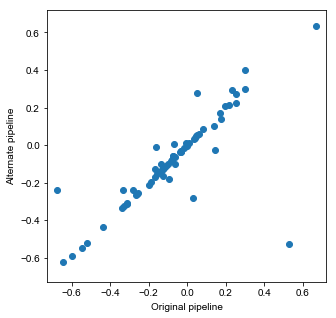

In [27]:

plt.figure(figsize=(5, 5))
plt.scatter(master['imbalance_orig'], master['imbalance_legacy'])
plt.xlabel('Original pipeline')
plt.ylabel('Alternate pipeline')

mi = master[['imbalance_orig', 'imbalance_legacy']].min(1).min()-0.05
ma = master[['imbalance_orig', 'imbalance_legacy']].max(1).max()+0.05
plt.xlim([mi, ma])
plt.ylim([mi, ma])



if save_images:
    export.export_image('{}/alternate_analysis_pipeline.pdf'.format(outfolder))



spearmanr(master['imbalance_orig'], master['imbalance_legacy'])

In [28]:
master[
    (master['imbalance_orig']>0) & 
    (master['imbalance_legacy']<0) 
]

,tissue,age,imbalance_orig,imbalance_legacy
24,Heart,18.0,0.526734,-0.52713
65,Lung,12.0,0.0295905,-0.28163
67,Lung,24.0,0.143915,-0.0238353


In [29]:
master[
    (master['imbalance_orig']<-0.2)
].sort_values('imbalance_orig')

,tissue,age,imbalance_orig,imbalance_legacy
48,LI,18.0,-0.678338,-0.241746
7,Blood,24.0,-0.646453,-0.624738
23,Kidney,24.0,-0.599801,-0.593565
47,SI,24.0,-0.548157,-0.548157
51,LI,24.0,-0.522198,-0.522347
39,Stomach,24.0,-0.438255,-0.438252
54,Cerebellum,9.0,-0.337097,-0.336979
3,BAT,24.0,-0.334887,-0.241689
49,LI,12.0,-0.326627,-0.326672
61,Esophagus,12.0,-0.311499,-0.311474


In [30]:
if save_images:
    export.export_full_frame(
        os.path.join(outfolder, 'imbalances.xlsx'),
        master.sort_values('imbalance_orig')
    )